# Training for the Hcal with sensor data

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd

import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: coopersimon. Use `wandb login --relogin` to force relogin


True

In [2]:
#df = pd.read_pickle("CNN_12k_pions_1-100.pkl")
#df = pd.read_pickle("Atlas_Hadron_15k.pkl")
#df1 = pd.read_pickle("15k_gammas_final.pkl")
#df2 = pd.read_pickle("15k_pions_final.pkl")
df1 = pd.read_pickle("15k_gammas_final_final.pkl")
df2 = pd.read_pickle("15k_pions_final_final.pkl")



In [3]:
#df_all = pd.concat([df1,df2],ignore_index=True)
train_gamma = df1[:10000]
train_pi = df2[:10000]

val_gamma = df1[-5000:]
val_pi = df2[-5000:]

train_all = pd.concat([train_gamma,train_pi])
val_all = pd.concat([val_gamma,val_pi])

In [2]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda:0 device


## Building the Network

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNmodel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNNmodel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv3d(in_channels, 16, kernel_size=3, padding="same")
        self.relu1 = nn.ReLU()
        # #self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv3d(16, 8, kernel_size=3, padding="same")
        self.relu2 = nn.ReLU()
        #self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding="same")
        self.relu3 = nn.ReLU()
        #self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        # Fully connected layers
        # self.fc1 = nn.Linear(16 * 20 * 5* 5, 32)
        self.fc1 = nn.Linear(60*3*3*8, 8)
        self.relu4 = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(8, num_classes)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.relu4(self.fc1(x))
        # x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)

        return x
model = CNNmodel(1,1).to(device)

In [6]:
def loss_fn(E_true, E_pred):

    assert E_true.shape == E_pred.shape, "Input shapes must match"
    squared_diff = (E_true - E_pred)**2 / E_true

    loss = torch.mean(squared_diff)

    return loss

In [7]:
learning_rate = 1e-5
batch_size = 64
epochs = 150

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
import torch
from torch.utils.data import Dataset
import numpy as np


# Custom dataset class
class CNNDataset(Dataset):
    def __init__(self, data, truth, n_layers, sensor_dim, transform=False):
        """
        Args:
            data (numpy.ndarray): The input data in the shape (num_samples, sensor_hits)
            truth (numpy.ndarray): The truth in the shape (num_samples, 1)
            n_layers (int): Number of active layers in the input data
            sensor_dim (int): Number of sensors in one dimension per layer
            transform (callable, optional): Optional transform to be applied to the data.
        """
        self.data = torch.tensor(np.reshape(data, (-1, 1, n_layers, sensor_dim, sensor_dim))).to(device)
        self.truth = torch.tensor(truth).to(device)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def processing(self, sample):
        return sample

    def __getitem__(self, idx):
        #sample = self.data.index_select[idx,:].values
        sample = self.data[idx]
        label = self.truth[idx]

        if self.transform:
            sample = self.processing(sample)

        return sample, label


In [16]:
#print("shape of the training data: ", df_photons['sensor_energy'].to_numpy(dtype = np.float32)[:10000].shape, "\nshape of the trainig_truth:", df_photons['true_energy'].to_numpy(dtype = np.float32)[:10000, None].shape , "\nshape of the validation data:", df_pions['sensor_energy'].to_numpy(dtype = np.float32)[10000:].shape, "\nshape of the val_truth:", df_pions['true_energy'].to_numpy(dtype = np.float32)[10000:, None].shape)
training_data = CNNDataset(train_all["sensor_energy"].to_numpy(dtype = np.float32), train_all['true_energy'].to_numpy(dtype = np.float32)[:, None],60,3)
val_data = CNNDataset(val_all["sensor_energy"].to_numpy(dtype = np.float32), val_all['true_energy'].to_numpy(dtype = np.float32)[:, None],60,3)

NameError: name 'train_all' is not defined

In [10]:
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size,shuffle=True)

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(y, pred)
        if batch == 0:
            # print(X, pred, y)
            print(X.shape, pred.shape, y.shape)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    wandb.log({"train_loss": loss.item()})


def val_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()

    val_loss /= num_batches
    correct /= size
    #log here wandb.log({"accuracy": acc, "loss": loss})
    wandb.log({"val_loss": val_loss})
    

    
    print(f"Val Error: \n Avg loss: {val_loss:>8f} \n")

In [15]:
# wandb.init(project="Cal_final_final", config={"learning_rate": learning_rate,
#                                                 "date": "15.10.2023",
#                                                 "epochs": epochs,
#                                                 "batch_size":  batch_size,
#                                                 "loss function": loss_fn,
#                                                 "Optimizer": optimizer})

# wandb.watch(model, log='all')

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loop(val_dataloader, model, loss_fn)
print("Done!")
wandb.finish()

Epoch 1
-------------------------------


NameError: name 'train_dataloader' is not defined

In [29]:
#save weights and biases
#torch.save(model.state_dict(), "CNN_final_final.torch") 

## Testing the model

In [11]:
#load the model with the saved weights and biases
#model = CNNmodel(1,1).to(device)
model.load_state_dict(torch.load("CNN_final_final.torch"))  # load model parameters
model

#load data
test_gamma = pd.read_pickle("5k_test_gammas_final_final.pkl")
test_pions = pd.read_pickle("5k_test_pions_final_final.pkl")

#put data together
test_all = pd.concat([test_gamma,test_pions])

#shuffle the dataframe
test_all = test_all.sample(frac=1).reset_index(drop=True)


In [23]:
test_dataset = CNNDataset(test_all["sensor_energy"].to_numpy(dtype = np.float32), test_all['true_energy'].to_numpy(dtype = np.float32)[:, None],60,3)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

def validation(model, device, valid_loader, loss_function):
    model.eval()
    loss_total = 0
    # Test validation data
    with torch.no_grad():
        for i, (features, labels) in enumerate(valid_loader):  # iterate over testloader
            features = features.to(device)
            labels = labels.to(device)
            output = model(features)  # calculate model output
            loss = loss_function(output, labels)  # calulate loss
            loss_total += loss.item()
    return loss_total / len(valid_loader)
    
def do_predictions(model, device, pred_loader):
    model.eval()
    truth = []
    outputs = []
    # Test validation data
    with torch.no_grad():
        for i, (features, labels) in enumerate(pred_loader):  # iterate over testloader
            features = features.to(device)
            labels = labels.to(device)
        
            output = model(features)  # calculate model output
           # print(output.to("cpu").detach().numpy())
            outputs.append(output.to("cpu").detach().numpy())
            truth.append(labels.to("cpu").detach().numpy())
    return outputs, truth
predictions, true_energy = do_predictions(model, device, test_dataloader)
best_loss = validation(model, device, test_dataloader, loss_fn)
print(best_loss)

0.19917682071874857


## Plots

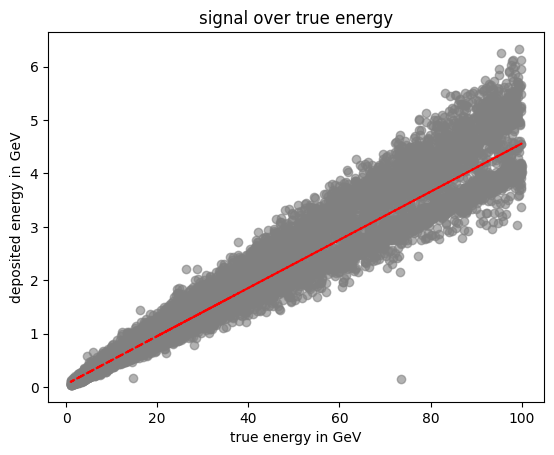

In [38]:
from scipy.optimize import curve_fit
#define fit function
def linear_fit(x,m,c):
    return m*x+c

#calculate fit parameters
popt, pcov = curve_fit(linear_fit, test_all["true_energy"].to_numpy(), test_all["total_dep_energy"].to_numpy())

# #create some energy between 1 and 100 GeV to have a smoother fitted function plotted
E = np.linspace(1,100,1000)

# #plot everything
plt.plot(test_all["true_energy"].to_numpy(),linear_fit(test_all["true_energy"].to_numpy(),*popt)/1000,'r--')   
plt.scatter(test_all["true_energy"],test_all["total_dep_energy"]/1000,color="grey",alpha=0.6)
plt.ylabel("deposited energy in GeV")
plt.xlabel("true energy in GeV")
plt.title("signal over true energy")
plt.savefig("signal_plot_cal_final_final.pdf")
plt.show()

In [39]:
model.eval()
tensored_data = torch.tensor(np.reshape(test_all["sensor_energy"].to_numpy(dtype=np.float32),(10000,1,60,3,3)))
#tensored_data = torch.tensor((df['sensor_energy'][10000:].to_numpy(dtype = np.float32) / 1000))
pred_values = model(tensored_data.to(device)).cpu().detach().numpy() #GeV

In [40]:
pred_values.shape

(10000, 1)

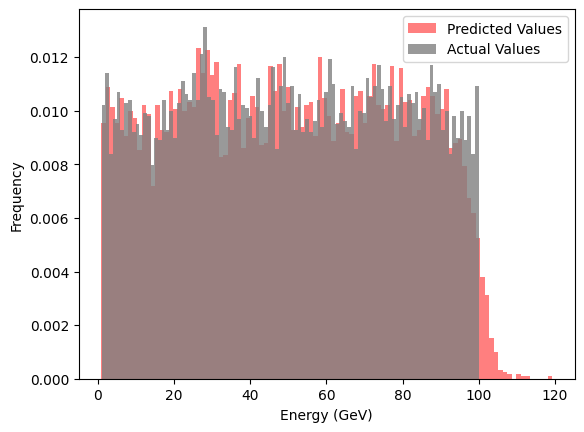

In [41]:
plt.hist(np.concatenate(pred_values), bins=100, density=True, alpha=0.5, label='Predicted Values',color = "red")
#plt.hist(df["total_dep_energy"]/1000, bins=100, density=True, alpha=0.5, label='Actual Values')
plt.hist(test_all["true_energy"].values, bins=100, density=True, alpha=0.8, label='Actual Values',color = "gray")
plt.xlabel('Energy (GeV)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.savefig("val_hist_cal_final_final.pdf")
plt.show()

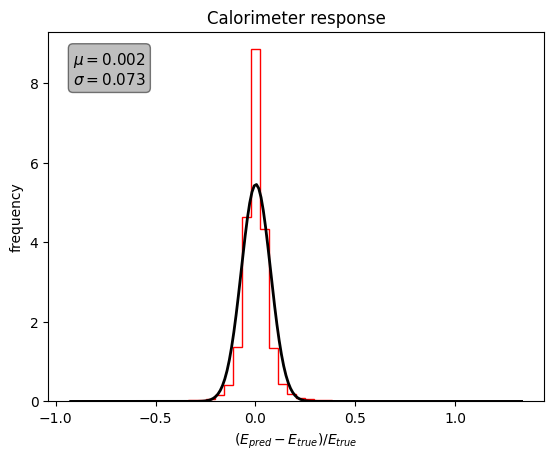

In [42]:
#new_response = (np.concatenate(pred_values) - df['true_energy'][15000:].to_numpy()) / df['true_energy'][15000:].to_numpy()
new_response = (np.concatenate(pred_values) - test_all["true_energy"].to_numpy()) / test_all["true_energy"].to_numpy()

fig, ax = plt.subplots()

ax.hist(new_response, bins=50, histtype='step', density=True, color = "red")
mu, std = np.mean(new_response), np.std(new_response)
textstr = '\n'.join((
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (std, )))
x = np.linspace(min(new_response), max(new_response), 200)
p = (1/(std * np.sqrt(2*np.pi)))* np.exp( - (x - mu)**2 / (2 * np.power(std,2)) )
ax.plot(x, p, 'k', linewidth=2)
props = dict(boxstyle='round', facecolor='grey', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)
plt.xlabel(r"$(E_{pred}-E_{true})/E_{true}$")
plt.ylabel("frequency")
plt.title("Calorimeter response")
plt.savefig("cal_response_final_final.pdf")
plt.show()

In [43]:
ranges = [(i, i+10) for i in range(0, 100, 10)]
dictionaries = {}
names=np.array([])
for start, end in ranges:
    mask = (test_all['true_energy'] >= start) & (test_all['true_energy'] < end)
    df_name = f'{start}to{end} GeV'
    names = np.append(names,df_name)
    dictionaries[df_name] = test_all[mask]
names

array(['0to10 GeV', '10to20 GeV', '20to30 GeV', '30to40 GeV',
       '40to50 GeV', '50to60 GeV', '60to70 GeV', '70to80 GeV',
       '80to90 GeV', '90to100 GeV'], dtype='<U32')

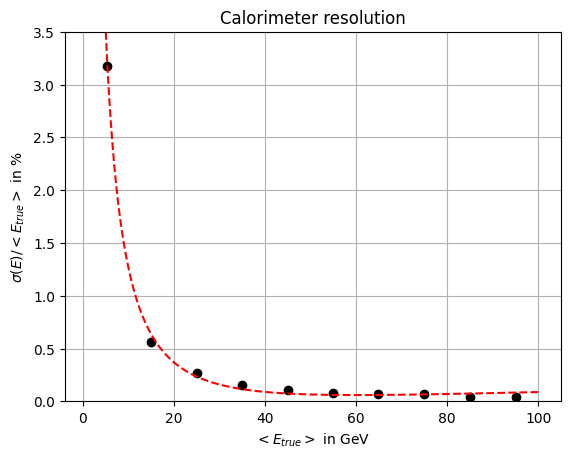

In [56]:
resolutions = []
mean_energies = []

for df_name in names:
    df_section = dictionaries[df_name]
    indices = df_section.index
    pred_values_section = np.concatenate(pred_values)[indices]
    true_energy_section = df_section['true_energy'].to_numpy()
    
    response = (pred_values_section - true_energy_section) / true_energy_section
    resolution = np.std(response)
    mean_energy = np.mean(true_energy_section)
    
    resolutions.append(resolution)
    mean_energies.append(mean_energy)

# Update resolutions array
resolutions = np.array(resolutions) / np.array(mean_energies)

#define plot function analogously to resolution function with contributions from "stochastic", "noise" and "constant" term
def fit_func(E,a,b,c):
    return a/np.sqrt(E)+b/E+c

# #fit the function to the data
popt, pcov = curve_fit(fit_func, mean_energies, resolutions)

# #create some energy between 1 and 100 GeV to have a smoother fitted function plotted
E = np.linspace(1,100,1000)

# #plot everything
plt.plot(mean_energies, resolutions*100, 'o', color = "black")
plt.plot(E,fit_func(E,*popt)*100,'r--',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel(r'$<E_{true}>$ in GeV')
plt.ylabel(r'$\sigma(E) / <E_{true}>$ in %')
plt.ylim(0,3.5)
plt.grid(True)
plt.title("Calorimeter resolution")
plt.savefig("cal_final_resolution.pdf")
plt.show()

## Resolution comparison between final and improved calorimeter

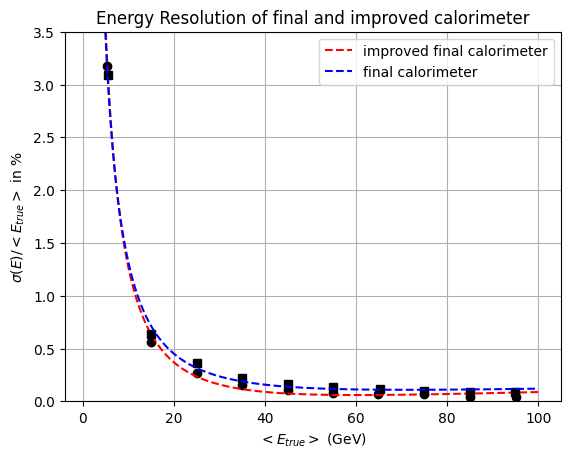

In [57]:
import pickle as pkl
resolutions = []
mean_energies = []

for df_name in names:
    df_section = dictionaries[df_name]
    indices = df_section.index
    pred_values_section = np.concatenate(pred_values)[indices]
    true_energy_section = df_section['true_energy'].to_numpy()
    
    response = (pred_values_section - true_energy_section) / true_energy_section
    resolution = np.std(response)
    mean_energy = np.mean(true_energy_section)
    
    resolutions.append(resolution)
    mean_energies.append(mean_energy)

# Update resolutions array
resolutions = np.array(resolutions) / np.array(mean_energies)

#define plot function analogously to resolution function with contributions from "stochastic", "noise" and "constant" term
def fit_func(E,a,b,c):
    return a/np.sqrt(E)+b/E+c

# #fit the function to the data
popt, pcov = curve_fit(fit_func, mean_energies, resolutions)

# #create some energy between 1 and 100 GeV to have a smoother fitted function plotted
E = np.linspace(1,100,1000)

#import resolutions and mean_energies from final calorimeter
with open('cal_final_resolutions.pkl','rb') as f:
    resolutions_final = pkl.load(f)
with open('cal_final_mean_energies.pkl','rb') as f:
    mean_energies_final = pkl.load(f)

#fit function to data
popt1, pcov1 = curve_fit(fit_func, mean_energies_final, resolutions_final)

#plot everything
plt.plot(mean_energies, resolutions*100, 'o', color = "black")
plt.plot(E,fit_func(E,*popt)*100,'r--',label="improved final calorimeter")
plt.plot(mean_energies_final, resolutions_final*100, 's', color = "black")
plt.plot(E,fit_func(E,*popt1)*100,'b--',label="final calorimeter")
plt.xlabel(r'$<E_{true}>$ (GeV)')
plt.ylabel(r'$\sigma(E) / <E_{true}>$ in %')
plt.ylim(0,3.5)
plt.grid(True)
plt.title("Energy Resolution of final and improved calorimeter")
plt.legend()
#plt.yscale("symlog")
plt.savefig("cal_resolution_both_calorimeter.pdf")
plt.show()